In [ ]:
# %load ~/repos/BrachyPhoton/pipeline_rnaseq/ptn.py
import re
RComp=re.compile
runID = RComp('[\^/](\d{1,4}[RC][_/].*)')
baseSpace = '(?P<lead>.*)_L(?P<chunk>\d+)_R(?P<read>[012])_(?P<trail>\d{1,4})\.(?P<ext>.+)'

In [ ]:
%%writefile ~/repos/BrachyPhoton/pipeline_rnaseq/ptn.py
import re
Rcomp=re.compile
ridL = r'(^|/)(\d{1,4}[RC]'
# ridL = r'(\d{1,4}[RC]'
end = r'[_\/\-]'
runID = Rcomp('.*%s).*'%(ridL,))
runCond = Rcomp('%s%s.*)'%(ridL,end))

baseSpace = Rcomp('(?P<lead>.*)_L(?P<chunk>\d+)_R(?P<read>[012])_(?P<trail>\d{1,4})\.(?P<ext>.+)')
sampleID = Rcomp('_(S\d{1,3})[_/\-\.]')

BdAcc = Rcomp('(Bradi[\da-zA-Z]+)')


import pymisca.util as pyutil
def getRUNid(fname):
#     pt = r'[\^/](\d{3}R)/'
    pt = runID
    res = re.findall(pt,fname)    
    return res[-1][-1] if res else None

def get_sampleID(fname):
    res = sampleID.findall(fname)    
    return res[0] if res else None
def getRUNid_full(fname):
    try:
        pt = r'[\^/](\d{3}R/[^/]+)/'
        res = re.findall(pt,fname)    
        return res[0] if res else None
    except:
#         print fname
        assert 0,fname
def getZT(fname):
    pt = '[/\^-](ZT[-]?\d{1,2})[-_\.]'
    res = re.findall(pt,fname)
    return res[0] if res else None
def getLight(fname):
    pt = '[/\-_]([LS]D)[\-_]'
    res = re.findall(pt,fname)
    return res[0] if res else None
def getGenotype(fname):
    pt = '[/\-_](elf3|ELF3-OX|Bd[^-]+)[\-_]'
    res = re.findall(pt,fname)
    res = res[0] if res else None
    if res is None:
        return res
    else:
        if not res.startswith('Bd'):
            res = 'Bd%s'%res
        res = res.replace('_','')
        res = res.replace('-','')
#         res = res.replace('-','_')
        return res
def getBrachy(fname):

    res= {k:f(fname) for k,f in {
        'RunID':getRUNid,
        'ZTime':getZT,
        'light':getLight,
        'gtype':getGenotype,
        'SampleID':get_sampleID,
    }.items()}
    return res
def add_ZTime_int(meta):
    vals = [ int(re.sub('[^-\d]','',x)) for x in meta['ZTime'] ]
    vals = [24+x if x <0 else x for x in vals]
    meta['ZTime_int'] = vals
#     meta['ZTime'] = pyutil.paste0([ ['ZT'] * len(meta),meta['ZTime_int']])
    return meta

    
    

In [294]:
# import pymisca as pyutil; reload(pyutil)
from synotil.ptn import *    
if __name__=='__main__':
#     import tmp
    import subprocess,re,sys
    import pandas as pd
    import pymisca.util as pyutil; reload(pyutil)

#     fnames = 
    Rid2Age={
        '150R':2,
        '148R':2,
        '149R':2,
        '144R':3,
        '143R':4,
        '169R':4,
    }
    
    INDIR = '/media/pw_synology3/BrachyPhoton/Mapped_data'
#     INDIR = [ '%s/%s'%(INDIR,x) for x in Rid2Age.keys()]
    res = subprocess.check_output("find %s -name *.stringtie.count"%INDIR,shell = 1).splitlines()
    assert res[-1]!='[FAIL]'
    fnames = res
    
    meta = {}
    vals = map(getRUNid,fnames)
    meta['RunID']=vals
    print vals

    vals = map(get_sampleID,fnames)
    meta['sampleID']=vals
    print vals
    
    vals = map(getRUNid_full,fnames)
    meta['RunID_full']=vals
    print vals

    vals = map(getZT,fnames)
    meta['ZTime']=vals

    vals = map(getLight,fnames)
    meta['light']=vals

    vals = map(getGenotype,fnames)
    vals = ['Bd21' if x=='BdWT' else x for x in vals]
    meta['gtype'] = vals
    

    meta = pd.DataFrame(meta)
    meta.loc[meta['RunID']=='143R','light'] = 'LD' 
    # meta[meta['RunI']]

    meta['Age_int'] = map(Rid2Age.get,meta['RunID'])
    meta['Age'] =[ 'Wk%d'%x for x in meta['Age_int']]

    #### Discussed with Mingjun on June 6th about 143R
#     meta['ZTime'][[4,5]] = 'ZT0'
    meta.loc[ (meta['RunID']=='143R' ) & ( meta['sampleID'].isin(['S5','S6']) ), 'ZTime'] = 'ZT0'
#     meta['ZTime'][[4,5]] = 'ZT0'

#     vals = [ int(re.sub('[^-\d]','',x)) for x in meta['ZTime'] ]
#     vals = [24+x if x <0 else x for x in vals]
#     meta['ZTime_int'] = vals
#     meta['ZTime'] = pyutil.paste0([ ['ZT'] * len(meta),meta['ZTime_int']])
    meta['ZTime_int'] = meta['ZTime'].str.strip('ZT').astype(int)

    meta = pyutil.col2meta(columns=pyutil.meta2name(meta))
    meta['header_'] = pyutil.meta2name(meta)
    meta['fname_'] = list(fnames)
    meta = meta.sort_values(['gtype','light','Age','ZTime_int',])

    
    meta.to_csv('meta.csv')
    meta
#     sys.exit(0)

is in ipython: 1
['150R', '150R', '150R', '150R', '150R', '150R', '150R', '150R', '148R', '148R', '148R', '148R', '148R', '148R', '148R', '148R', '149R', '149R', '149R', '149R', '149R', '149R', '149R', '149R', '144R', '144R', '144R', '144R', '144R', '144R', '144R', '144R', '144R', '144R', '144R', '144R', '143R', '143R', '143R', '143R', '143R', '143R', '169R', '169R', '169R', '169R', '169R', '169R', '169R', '169R']
['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S1', 'S2', 'S3', 'S4', 'S6', 'S5', 'S7', 'S8', 'S16', 'S17', 'S19', 'S18', 'S20', 'S21', 'S22', 'S23', 'S10', 'S11', 'S12', 'S13', 'S14', 'S16', 'S15', 'S17', 'S19', 'S18', 'S20', 'S21', 'S1', 'S2', 'S4', 'S3', 'S5', 'S6', 'S17', 'S18', 'S19', 'S25', 'S20', 'S26', 'S28', 'S27']
['150R/Doro_150R_Doro_1-43239982', '150R/Doro_150R_Doro_2-43251379', '150R/Doro_150R_Doro_3-43251380', '150R/Doro_150R_Doro_4-43251381', '150R/Doro_150R_Doro_5-43237929', '150R/Doro_150R_Doro_6-43247396', '150R/Doro_150R_Doro_7-43240922', '150R/Doro_150

In [295]:

import synotil.util as sutil;reload(sutil)
import pymisca.util as pyutil; reload(pyutil)

is in ipython: 1


<module 'pymisca.util' from '/home/feng/.local/lib/python2.7/site-packages/pymisca/util.pyc'>

In [296]:
%%time
# fnames 
# meta.fname
# fnames = meta
mcurr = meta[:5]
mcurr = meta
fnames = mcurr.fname_
df = pyutil.Table2Mat(fnames = fnames, match='Bradi',valCol = 'TPM', idCol='Gene ID',
                      callback=sutil.tidyBd,
#                       callback=None,
                     )
df.columns = df.columns.map(pyutil.df2mapper(mcurr,'fname_','header_').get)
# df.columns = mcurr.header_


dfc = df
dfc = dfc.apply(sutil.log2p1)
rnaseq = dfc
fname = '/home/feng/data/rnaseq/Bd_annotated-only_log2-1p.pk'
print dfc.shape
dfc.to_pickle(fname)

(34310, 50)
CPU times: user 22.7 s, sys: 3.55 s, total: 26.3 s
Wall time: 26.9 s


In [297]:
rnaseq.head()

,Age=Wk2_RunID=150R_ZTime=ZT0_gtype=Bd21_light=LD_sampleID=S1,Age=Wk2_RunID=150R_ZTime=ZT1_gtype=Bd21_light=LD_sampleID=S2,Age=Wk2_RunID=150R_ZTime=ZT4_gtype=Bd21_light=LD_sampleID=S3,Age=Wk2_RunID=150R_ZTime=ZT8_gtype=Bd21_light=LD_sampleID=S4,Age=Wk2_RunID=150R_ZTime=ZT12_gtype=Bd21_light=LD_sampleID=S5,Age=Wk2_RunID=150R_ZTime=ZT16_gtype=Bd21_light=LD_sampleID=S6,Age=Wk2_RunID=150R_ZTime=ZT20_gtype=Bd21_light=LD_sampleID=S7,Age=Wk2_RunID=150R_ZTime=ZT22_gtype=Bd21_light=LD_sampleID=S8,Age=Wk4_RunID=143R_ZTime=ZT0_gtype=Bd21_light=LD_sampleID=S5,Age=Wk4_RunID=169R_ZTime=ZT0_gtype=Bd21_light=LD_sampleID=S17,...,Age=Wk2_RunID=149R_ZTime=ZT22_gtype=Bdelf3_light=SD_sampleID=S23,Age=Wk3_RunID=144R_ZTime=ZT-8_gtype=Bdelf3_light=SD_sampleID=S21,Age=Wk3_RunID=144R_ZTime=ZT-4_gtype=Bdelf3_light=SD_sampleID=S16,Age=Wk3_RunID=144R_ZTime=ZT0_gtype=Bdelf3_light=SD_sampleID=S17,Age=Wk3_RunID=144R_ZTime=ZT4_gtype=Bdelf3_light=SD_sampleID=S18,Age=Wk3_RunID=144R_ZTime=ZT8_gtype=Bdelf3_light=SD_sampleID=S19,Age=Wk3_RunID=144R_ZTime=ZT12_gtype=Bdelf3_light=SD_sampleID=S20,Age=Wk4_RunID=143R_ZTime=ZT0_gtype=Bdphyc_light=LD_sampleID=S6,Age=Wk4_RunID=143R_ZTime=ZT8_gtype=Bdphyc_light=LD_sampleID=S2,Age=Wk4_RunID=143R_ZTime=ZT16_gtype=Bdphyc_light=LD_sampleID=S4
Bradi0012s00100,6.493270,7.549545,7.307836,7.282132,7.266319,7.986393,7.958354,7.891681,7.482517,8.246779,...,7.574150,8.220843,6.536464,6.201096,8.300886,8.031206,8.818151,8.490403,7.207545,8.254339
Bradi0012s00201,0.476744,0.123954,0.341382,0.112265,0.067706,0.185204,0.459999,0.453568,0.209592,0.690182,...,0.388334,1.167757,0.622867,1.271078,1.359644,1.317860,1.378837,0.773385,0.169239,0.405462
Bradi0014s00100,2.198008,1.956582,3.181279,3.253537,3.270988,3.698204,3.073804,3.221868,2.883060,4.256388,...,3.454066,4.177592,3.490139,3.710770,4.091785,3.774241,4.053566,3.233987,2.326282,3.372694
Bradi0135s00100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Bradi0180s00100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [300]:
# tracks[2]
# dfc = rnaseq_ldsd_joint.reindex(['Bradi2g62067'])
# cols = dfc.columns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def plotter(dfc):
    plt.figure()
    dfc = dfc.reindex(['Bradi2g62067'])
#     cols = dfc.colName_short()
    cols = scount.countMatrix.colName_short(dfc,)
#     cols = dfc.columns
    ys = dfc.values.ravel()
    
    ys = np.exp(ys)-1
    
    plt.plot(ys,)
    plt.xticks(range(len(cols)),cols,rotation='vertical');
    plt.ylabel('TPM')
    plt.title(dfc.index[0])
    plt.grid()

# # print dfc.shape
# plotter(dfc.get(dfc.columns[:8]))
# plotter(dfc.get(dfc.columns[8:]))

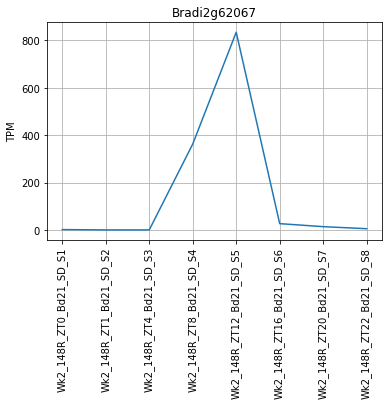

In [301]:
mcurr = meta.query('Age=="Wk2" & gtype== "Bd21"')
mcurr = mcurr.query('light=="SD"')
dfc = rnaseq.get(mcurr.header_)
plotter(dfc)

In [282]:
??pyutil.argsortByRef


 [WARN] unable to simplify condName. Exception:list index out of range


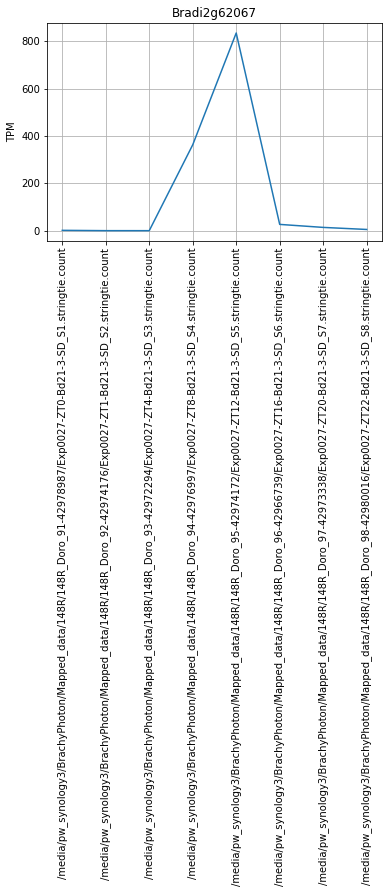

In [302]:
mcurr = meta.query('Age=="Wk2" & gtype== "Bd21"')
mcurr = mcurr.query('light=="SD"')

dfc = pyutil.Table2Mat(mcurr.fname_, callback=sutil.tidyBd)
dfc = dfc.apply(sutil.log2p1)
plotter(dfc)

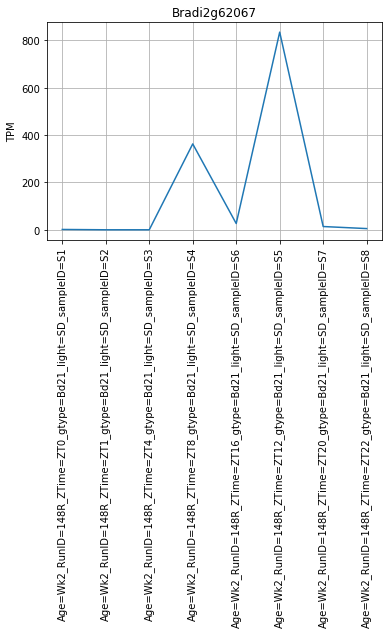

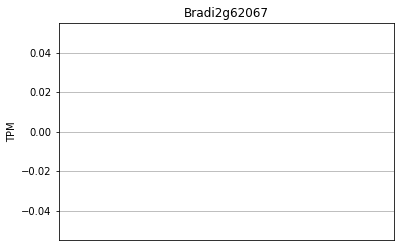

In [268]:
dfc = pyutil

dfc = dfc.reindex(['Bradi2g62067'])
# dfc = dfc.reindex(['Bradi2g62067.v3.1'])
plotter(dfc.get(dfc.columns[:8]))
plotter(dfc.get(dfc.columns[8:]))

In [36]:
# df.to_pickle


In [122]:
list(mcurr.header_)

['Age=Wk2_RunID=148R_ZTime=ZT0_gtype=Bd21_light=SD_sampleID=S1',
 'Age=Wk2_RunID=148R_ZTime=ZT1_gtype=Bd21_light=SD_sampleID=S2',
 'Age=Wk2_RunID=148R_ZTime=ZT4_gtype=Bd21_light=SD_sampleID=S3',
 'Age=Wk2_RunID=148R_ZTime=ZT8_gtype=Bd21_light=SD_sampleID=S4',
 'Age=Wk2_RunID=148R_ZTime=ZT16_gtype=Bd21_light=SD_sampleID=S6',
 'Age=Wk2_RunID=148R_ZTime=ZT12_gtype=Bd21_light=SD_sampleID=S5',
 'Age=Wk2_RunID=148R_ZTime=ZT20_gtype=Bd21_light=SD_sampleID=S7',
 'Age=Wk2_RunID=148R_ZTime=ZT22_gtype=Bd21_light=SD_sampleID=S8']

In [30]:
# meta.header_[0]
col = pyutil.col2meta(df)
pyutil.meta2name(col)

'Age=Wk2_RunID=150R_ZTime=ZT0_gtype=Bd21_light=LD_sampleID=S1'

In [23]:
%matplotlib inline

In [123]:
sutil.qc_Sort(df=dfc);

IndexError: too many indices for array

In [108]:
! cp /home/feng/repos/BrachyPhoton/pipeline_rnaseq/ptn.py compile_meta.py
! python compile_meta.py

is in ipython: 0
[WARN] pymisca.vis_util cannot find network
['150R', '150R', '150R', '150R', '150R', '150R', '150R', '150R', '148R', '148R', '148R', '148R', '148R', '148R', '148R', '148R', '149R', '149R', '149R', '149R', '149R', '149R', '149R', '149R', '144R', '144R', '144R', '144R', '144R', '144R', '144R', '144R', '144R', '144R', '144R', '144R', '143R', '143R', '143R', '143R', '143R', '143R', '169R', '169R', '169R', '169R', '169R', '169R', '169R', '169R']
['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S1', 'S2', 'S3', 'S4', 'S6', 'S5', 'S7', 'S8', 'S16', 'S17', 'S19', 'S18', 'S20', 'S21', 'S22', 'S23', 'S10', 'S11', 'S12', 'S13', 'S14', 'S16', 'S15', 'S17', 'S19', 'S18', 'S20', 'S21', 'S1', 'S2', 'S4', 'S3', 'S5', 'S6', 'S17', 'S18', 'S19', 'S25', 'S20', 'S26', 'S28', 'S27']
['150R/Doro_150R_Doro_1-43239982', '150R/Doro_150R_Doro_2-43251379', '150R/Doro_150R_Doro_3-43251380', '150R/Doro_150R_Doro_4-43251381', '150R/Doro_150R_Doro_5-43237929', '150R/Doro_150R_Doro_6-43247396', '150

In [138]:
! cd  ~/repos/BrachyPhoton;./setup.py install --user
import synotil.ptn as spt;reload(spt)
spt.getBrachy(fnames[0])

running install
running build
running build_py
copying pipeline_rnaseq/ptn.py -> build/lib.linux-x86_64-2.7/synotil
running install_lib
copying build/lib.linux-x86_64-2.7/synotil/ptn.py -> /home/feng/.local/lib/python2.7/site-packages/synotil
byte-compiling /home/feng/.local/lib/python2.7/site-packages/synotil/ptn.py to ptn.pyc
running install_egg_info
Removing /home/feng/.local/lib/python2.7/site-packages/synotil-1.0.egg-info
Writing /home/feng/.local/lib/python2.7/site-packages/synotil-1.0.egg-info


{'RunID': '150R',
 'SampleID': 'S1',
 'ZTime': 'ZT0',
 'gtype': 'Bd21',
 'light': 'LD'}

In [110]:
meta= pd.read_csv('meta.csv')

In [111]:
meta

,Unnamed: 0,RunID,RunID_full,ZTime,gtype,light,sampleID,Age_int,Age,ZTime_int,fname
0,0,150R,150R/Doro_150R_Doro_1-43239982,ZT0,Bd21,LD,S1,2,Wk2,0,/media/pw_synology3/BrachyPhoton/Mapped_data/1...
1,1,150R,150R/Doro_150R_Doro_2-43251379,ZT1,Bd21,LD,S2,2,Wk2,1,/media/pw_synology3/BrachyPhoton/Mapped_data/1...
2,2,150R,150R/Doro_150R_Doro_3-43251380,ZT4,Bd21,LD,S3,2,Wk2,4,/media/pw_synology3/BrachyPhoton/Mapped_data/1...
3,3,150R,150R/Doro_150R_Doro_4-43251381,ZT8,Bd21,LD,S4,2,Wk2,8,/media/pw_synology3/BrachyPhoton/Mapped_data/1...
4,4,150R,150R/Doro_150R_Doro_5-43237929,ZT12,Bd21,LD,S5,2,Wk2,12,/media/pw_synology3/BrachyPhoton/Mapped_data/1...
5,5,150R,150R/Doro_150R_Doro_6-43247396,ZT16,Bd21,LD,S6,2,Wk2,16,/media/pw_synology3/BrachyPhoton/Mapped_data/1...
6,6,150R,150R/Doro_150R_Doro_7-43240922,ZT20,Bd21,LD,S7,2,Wk2,20,/media/pw_synology3/BrachyPhoton/Mapped_data/1...
7,7,150R,150R/Doro_150R_Doro_8-43250398,ZT22,Bd21,LD,S8,2,Wk2,22,/media/pw_synology3/BrachyPhoton/Mapped_data/1...
8,8,148R,148R/148R_Doro_91-42978987,ZT0,Bd21,SD,S1,2,Wk2,0,/media/pw_synology3/BrachyPhoton/Mapped_data/1...
9,9,148R,148R/148R_Doro_92-42974176,ZT1,Bd21,SD,S2,2,Wk2,1,/media/pw_synology3/BrachyPhoton/Mapped_data/1...


In [22]:
res[-1]

'/bin/bash: -c: line 1: syntax error: unexpected end of file'

In [23]:
    #     INDIR = '/media/pw_synology3/BrachyPhoton/Mapped_data/./150R'
    res = !find {INDIR} -name *.stringtie.count
    res

['/media/pw_synology3/BrachyPhoton/Mapped_data/133R/BdPIFs-32747730/133E_23_DN-40235206/Exp13-TP19-1411-LD_S23.stringtie.count',
 '/media/pw_synology3/BrachyPhoton/Mapped_data/150R/Doro_150R_Doro_1-43239982/Doro-Bd21-3-ZT0-LD_S1.stringtie.count',
 '/media/pw_synology3/BrachyPhoton/Mapped_data/150R/Doro_150R_Doro_2-43251379/Doro-Bd21-3-ZT1-LD_S2.stringtie.count',
 '/media/pw_synology3/BrachyPhoton/Mapped_data/150R/Doro_150R_Doro_3-43251380/Doro-Bd21-3-ZT4-LD_S3.stringtie.count',
 '/media/pw_synology3/BrachyPhoton/Mapped_data/150R/Doro_150R_Doro_4-43251381/Doro-Bd21-3-ZT8-LD_S4.stringtie.count',
 '/media/pw_synology3/BrachyPhoton/Mapped_data/150R/Doro_150R_Doro_5-43237929/Doro-Bd21-3-ZT12-LD_S5.stringtie.count',
 '/media/pw_synology3/BrachyPhoton/Mapped_data/150R/Doro_150R_Doro_6-43247396/Doro-Bd21-3-ZT16-LD_S6.stringtie.count',
 '/media/pw_synology3/BrachyPhoton/Mapped_data/150R/Doro_150R_Doro_7-43240922/Doro-Bd21-3-ZT20-LD_S7.stringtie.count',
 '/media/pw_synology3/BrachyPhoton/Mapped_

In [2]:
! wc -l meta.csv

9 meta.csv


In [5]:
if __name__=='__main__':
    !jupyter nbconvert --to python compile_meta.ipynb
#     !python compile_meta.ipynb && echo '[succ]'

[NbConvertApp] Converting notebook compile_meta.ipynb to python
[NbConvertApp] Writing 2585 bytes to compile_meta.py
